In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

from scipy.stats import poisson, norm, invgamma, uniform

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
J = 6

np.random.seed(111)
N = poisson.rvs(3, size=J, loc=10)

MU  = -9
TAU = 1
GAMMA = 2
ZETA = 3
RHO = 3
NU  = 4

np.random.seed(111)
ALPHA  = norm.rvs(size=J, loc=MU, scale=TAU)
BETA   = norm.rvs(size=J, loc=GAMMA, scale=ZETA)
SIGMA2 = invgamma.rvs(size=J, a=NU/2, scale=NU/2*RHO**2)

SIGMA = np.sqrt(SIGMA2)

VARIABLE = 'Y'
PREDICTOR = 'X'

ALPHA_LEVEL = 0.05

Create the data

In [3]:
np.random.seed(111)
X = uniform.rvs(size=N[0])
Y = norm.rvs(size=N[0], loc=ALPHA[0] + BETA[0] * (X-np.mean(X)), scale=SIGMA[0])
Dat = pd.DataFrame(np.array([Y, X, [0]*N[0]]).T)

for j in range(1,J):
    X = uniform.rvs(size=N[j])
    Y = norm.rvs(size=N[j], loc=ALPHA[j] + BETA[j] * (X-np.mean(X)), scale=SIGMA[j])
    DatAux = pd.DataFrame(np.array([Y, X, [j]*N[j]]).T)
    Dat = pd.concat([Dat, DatAux])

Dat = Dat.rename(columns={0:VARIABLE, 1:PREDICTOR, 2:'Region'})
Dat['Region'] = Dat['Region'].astype(int)

In [4]:
Dat = Dat[[VARIABLE, PREDICTOR]]

In [5]:
PredictorMean = Dat[PREDICTOR].mean()

---

Regression model with common $\alpha$ and $\beta$

In [6]:
with pm.Model() as ModelCommonAlphaCommonBeta:
    Alpha = pm.Flat('Alpha')
    Beta  = pm.Flat('Beta')

    Sigma = pm.HalfFlat('Sigma')
    pm.Potential('p(Sigma)', 1/Sigma)

    MeanIncome = pm.Deterministic('MeanIncome', Alpha + Beta * (Dat[PREDICTOR] - PredictorMean))

    Income = pm.Normal('Income', mu=MeanIncome, sigma=Sigma, observed=Dat[VARIABLE])

Get a sample from the posterior and the posterior predictive

In [7]:
with ModelCommonAlphaCommonBeta:
    TraceCommonAlphaCommonBeta = pm.sample()
    TraceCommonAlphaCommonBeta.extend(pm.sample_posterior_predictive(TraceCommonAlphaCommonBeta))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [Income]


---

National average income, ratio of income per year-of-education

Text(0.5, 1.0, 'Posterior distribution of $\\beta$')

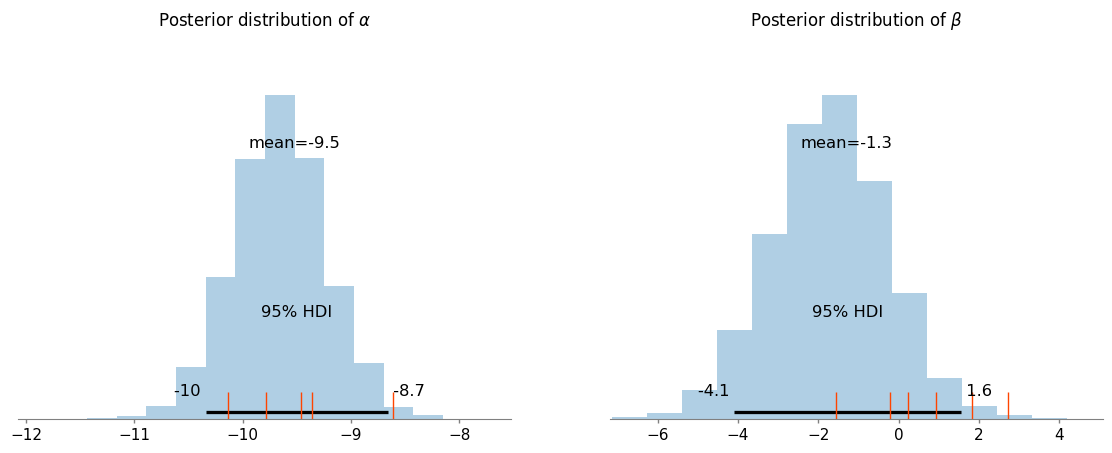

In [12]:
_, axes = plt.subplots(1,2, figsize=(14,5))

az.plot_posterior(
    TraceCommonAlphaCommonBeta
    , var_names = ['Alpha', 'Beta']
    , hdi_prob = 1-ALPHA_LEVEL
    , kind = 'hist'
    , textsize=11
    , ax = axes
)

sns.rugplot(ALPHA, ax=axes[0], color='orangered', height=0.07)
sns.rugplot(BETA, ax=axes[1], color='orangered', height=0.07)

axes[0].set_title(r"Posterior distribution of $\alpha$")
axes[1].set_title(r"Posterior distribution of $\beta$")

Scatterplot

Text(0.5, 0, 'X')

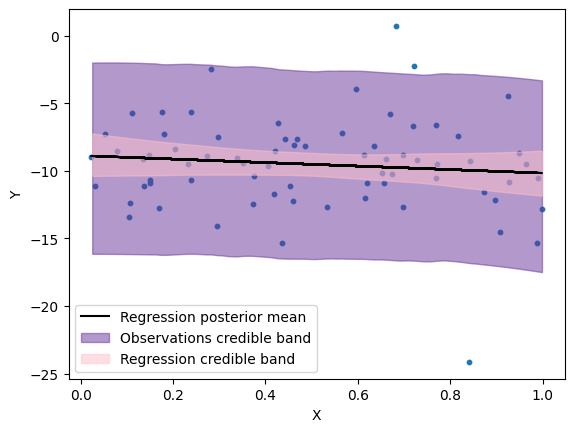

In [9]:
plt.scatter(x=Dat[PREDICTOR], y=Dat[VARIABLE], s=10)

plt.plot(
    Dat[PREDICTOR]
    , TraceCommonAlphaCommonBeta.posterior.MeanIncome.mean(('chain', 'draw'))
    , label="Regression posterior mean"
    , color='k'
)

az.plot_hdi(
    Dat[PREDICTOR]
    , TraceCommonAlphaCommonBeta.posterior_predictive.Income
    , hdi_prob=1-ALPHA_LEVEL
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Observations credible band"}
)

az.plot_hdi(
    Dat[PREDICTOR]
    , TraceCommonAlphaCommonBeta.posterior.MeanIncome
    , hdi_prob=1-ALPHA_LEVEL
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':"Regression credible band"}
)

plt.legend()

plt.ylabel(VARIABLE)
plt.xlabel(PREDICTOR)